In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!pip install fastai

  Obtaining dependency information for fastai from https://files.pythonhosted.org/packages/79/ab/70ca55249e17b735af0dde65d9844392b8705260521b91d04286ba87a9e5/fastai-2.7.14-py3-none-any.whl.metadata
  Obtaining dependency information for fastdownload<2,>=0.0.5 from https://files.pythonhosted.org/packages/47/60/ed35253a05a70b63e4f52df1daa39a6a464a3e22b0bd060b77f63e2e2b6a/fastdownload-0.0.7-py3-none-any.whl.metadata
  Obtaining dependency information for fastcore<1.6,>=1.5.29 from https://files.pythonhosted.org/packages/39/b8/3059245adb5e4421222aab3852ac7f47d68eba82c8c62b88928ec1c69431/fastcore-1.5.29-py3-none-any.whl.metadata
  Obtaining dependency information for torchvision>=0.11 from https://files.pythonhosted.org/packages/e7/45/419aa0b37254f1fd62b45bb63836066c5eb81e37d70940e0491e95167eed/torchvision-0.17.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/61/11/1812ef6cbd7433ad240f72161ce5f84c4c450cede4db0803


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#For example, so not exported
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.vision.all import *

In [3]:
from pathlib import Path

In [4]:
import numpy as np

In [5]:
import os
import shutil
import random
os.environ['FASTAI_TB_BACKEND'] = 'pytorch'

In [7]:
!export FASTAI_TB_BACKEND='auto'

In [26]:
!pip install torchmetrics
from torchmetrics import Accuracy

  Obtaining dependency information for torchmetrics from https://files.pythonhosted.org/packages/f3/0e/cedcb9c8aeb2d1f655f8d05f841b14d84b0a68d9f31afae4af55c7c6d0a9/torchmetrics-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for lightning-utilities>=0.8.0 from https://files.pythonhosted.org/packages/ca/7d/16afeaef22e9863a4ba1de55ffca3a85167d119ff6c6cc2373c4b1b3e253/lightning_utilities-0.11.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/841.5 kB ? eta -:--:--
   ---------------------------------------- 10.2/841.5 kB ? eta -:--:--
   ----- ---------------------------------- 122.9/841.5 kB 1.8 MB/s eta 0:00:01
   ----------------- ---------------------- 358.4/841.5 kB 3.2 MB/s eta 0:00:01
   ----------------------------- ---------- 614.4/841.5 kB 4.3 MB/s eta 0:00:01
   ---------------------------------------- 841.5/841.5 kB 4.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Data

In [7]:
root_dir = 'COVID-19 Radiography Database'

In [8]:
# Here we move the data

def create_directories(root_dir, directories):
    for directory in directories:
        os.mkdir(os.path.join(root_dir, directory))

def rename_directories(root_dir, source_dirs, class_names):
    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

def create_class_directories(root_dir, directories, class_names):
    for directory in directories:
        for c in class_names:
            os.mkdir(os.path.join(root_dir, directory, c))

def move_images(root_dir, class_names, directory, percentage):
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        sample_size = int(len(images) * percentage)
        selected_images = random.sample(images, sample_size)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, directory, c, image)
            shutil.move(source_path, target_path)

# Configuration
class_names = ['normal', 'viral', 'covid']
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']
train_percentage = 0.70
test_percentage = 0.50         # use 50% of the remaining data after we move the train (15%)
validation_percentage = 1      # use 100% of the remaining data after we move the train (15%)
directories = ['test', 'train', 'valid']

# Execution
if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    create_directories(root_dir, directories)
    rename_directories(root_dir, source_dirs, class_names)
    create_class_directories(root_dir, directories, class_names)

    move_images(root_dir, class_names, 'train', train_percentage)
    move_images(root_dir, class_names, 'valid', validation_percentage)
    move_images(root_dir, class_names, 'test', test_percentage)

In [8]:
path = Path(root_dir)

# Get all the image files in the dataset directory
items = get_image_files(path)

# Define the splitter
splitter = GrandparentSplitter(train_name='train', valid_name='valid')
splits = splitter(items)

# Use the splits to create the training and validation sets
train_items = items[splits[0]]
valid_items = items[splits[1]]

In [9]:
print(len(train_items))
print(len(valid_items))

2679
1150


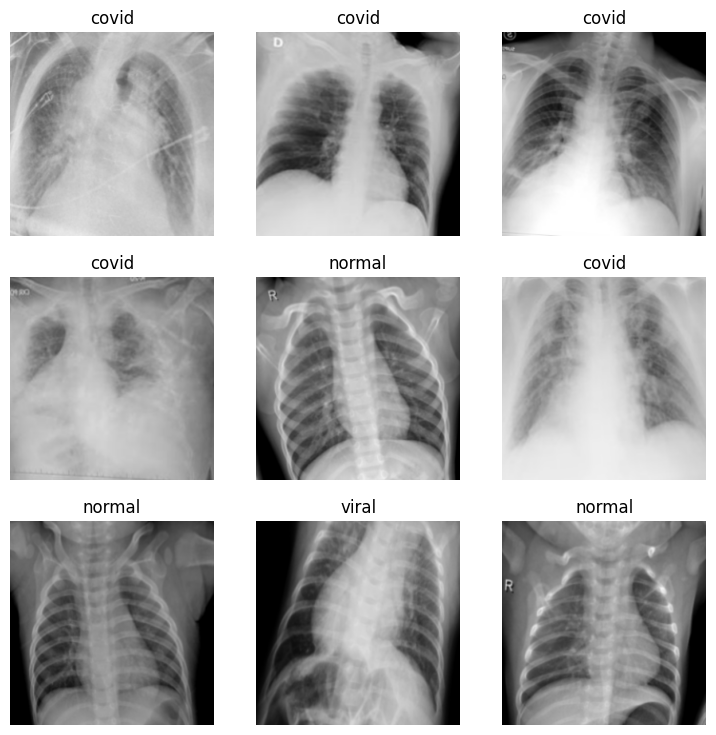

In [10]:
np.random.seed(41)

# Define the DataBlock
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
                   get_y=parent_label,
                   item_tfms=Resize(256),
                   batch_tfms=aug_transforms(size=256, min_scale=0.75))

# Create the DataLoaders
dls = dblock.dataloaders(path)

# Show a batch of data
dls.show_batch()

In [11]:
dls.vocab, dls.c, len(dls.train_ds), len(dls.valid_ds)

(['covid', 'normal', 'viral'], 3, 2679, 1150)

In [12]:
print("Number of examples in training:", len(dls.train_ds))
print("Number of examples in validation:", len(dls.valid_ds))

Number of examples in training: 2679
Number of examples in validation: 1150


In [13]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64]))

---

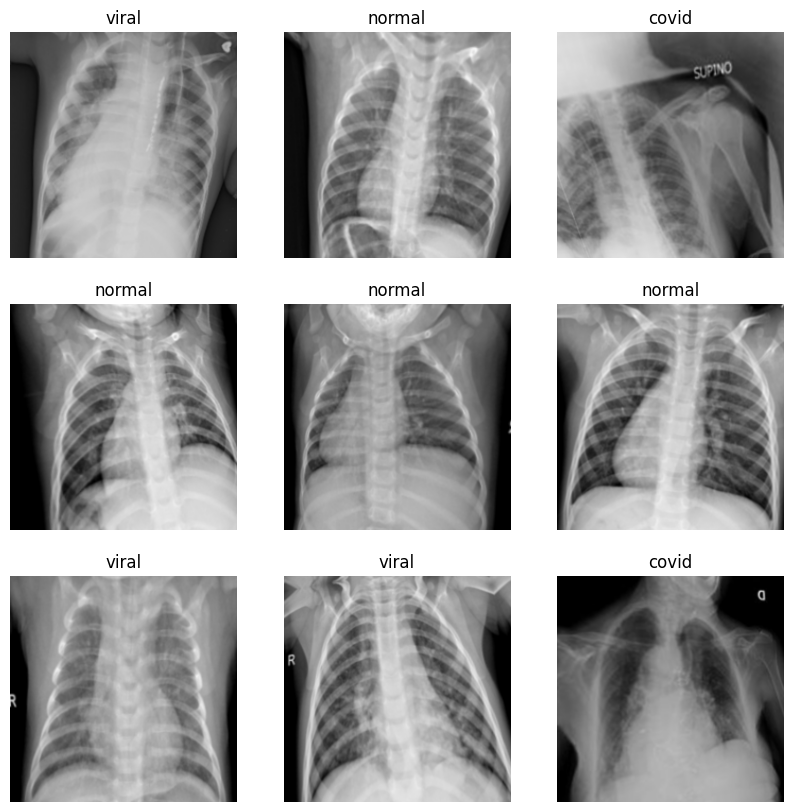

In [15]:
dls.show_batch(nrows=3, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [14]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [15]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [16]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [17]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    nn.Conv2d(256, 3, kernel_size=3, stride=1, padding=1),  # Change conv_layer to nn.Conv2d
    Flatten(),
    nn.Linear(507, 3)
)

In [18]:
learn = Learner(dls,
                model,
                loss_func=nn.CrossEntropyLoss(),
                metrics=accuracy)

In [19]:
print(learn.summary())

Sequential (Input shape: 64 x 3 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8 x 256 x 256  
Conv2d                                    216        True      
BatchNorm2d                               16         True      
LeakyReLU                                                      
____________________________________________________________________________
                     64 x 8 x 128 x 128  
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 16 x 128 x 128 
Conv2d                                    1152       True      
BatchNorm2d                               32         True      
LeakyReLU                                                      
____________________________________________________________________________
                     64 x 16 x 64 x 64   
MaxPool2d                                   

In [20]:
learn.fit_one_cycle(100, lr_max=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.439861,1.489052,0.509565,03:29
1,0.356806,0.554833,0.805217,03:25
2,0.296235,0.235944,0.909565,03:21
3,0.241299,0.331707,0.879130,03:22
4,0.217641,0.800011,0.751304,03:21
5,0.230841,0.307847,0.885217,03:23
6,0.223020,0.310163,0.899130,03:22
7,0.212518,0.699896,0.752174,03:21
8,0.201485,0.487148,0.826087,03:22
9,0.208775,0.475238,0.838261,03:21


In [21]:
learn.save('covid_model')

Path('models/covid_model.pth')

## Load Model

In [ ]:
learn.load('covid_model')

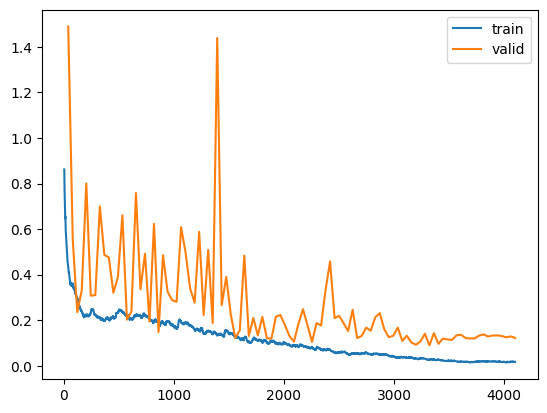

In [22]:
learn.recorder.plot_loss()

In [23]:
print("Number of examples in testing:", len(dls.valid_ds))

Number of examples in testing: 1150


In [24]:
predictions, targets = learn.get_preds(ds_idx=1) # Predicting without TTA on the validation set

In [25]:
# Get the index of the maximum value along the class dimension
class_predictions = torch.argmax(predictions, dim=1)

print(predictions)
print(targets)

tensor([[ 24.0255,  -7.6378,  -3.7862],
        [ 17.0062,  -6.1791,  -1.9525],
        [ 14.0635,  -4.7996,  -2.8551],
        ...,
        [-12.1861,  -5.7114,  10.6918],
        [-15.2520,  -9.1961,  14.9563],
        [-11.4950,   2.6140,   2.4949]])
tensor([0, 0, 0,  ..., 2, 2, 2])


In [27]:
accuracy = Accuracy(task="multiclass", num_classes=3)
x = accuracy(predictions,targets)
print(x.item())

0.9747825860977173


In [28]:
dls.vocab, dls.c, len(dls.train_ds), len(dls.valid_ds)

(['covid', 'normal', 'viral'], 3, 2679, 1150)

In [29]:
predictions = np.argmax(predictions, axis=1)
correct = 0
for idx, pred in enumerate(predictions):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(predictions)
print(len(predictions), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, predictions)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = predictions
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

1150 1121 0.9747826086956521
[[338   4   1]
 [  0 397   6]
 [  0  18 386]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.99      0.99       343
 No_findings       0.95      0.99      0.97       403
   Pneumonia       0.98      0.96      0.97       404

    accuracy                           0.97      1150
   macro avg       0.98      0.98      0.98      1150
weighted avg       0.98      0.97      0.97      1150



In [30]:
interp = ClassificationInterpretation.from_learner(learn)

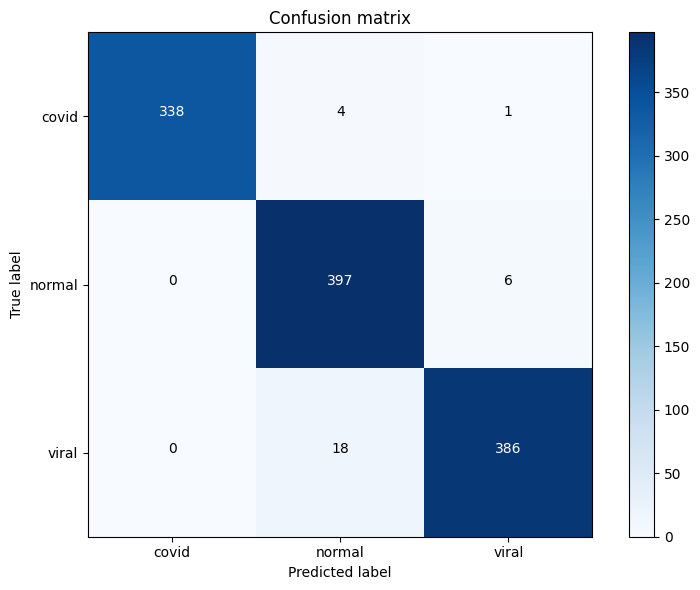

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Assuming `interp` is your ClassificationInterpretation object
_, targs, decoded = interp.learn.get_preds(dl=interp.dl, with_decoded=True)

# Convert multi-dimensional array to single-label array
decoded_single_label = torch.argmax(decoded, dim=1).numpy()

# Calculate confusion matrix
cm = confusion_matrix(targs.numpy(), decoded_single_label)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

# Add class labels
# Add class labels
num_classes = len(interp.dl.vocab)
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, interp.dl.vocab)
plt.yticks(tick_marks, interp.dl.vocab)

# Add annotations
thresh = cm.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Save the figure
plt.savefig('confusion_matrix.png')

In [36]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(targets, class_predictions)
print(conf_matrix)

[[338   4   1]
 [  0 397   6]
 [  0  18 386]]
